#***BBM 418 COMPUTER VISION: ASSIGNMENT 4***
# **Object Detection with Custom Overfeat and Pre-trained YOLO Algorithms**


##Problem Definition

The objective of this assignment is to develop an Overfeat Object Detector from scratch to classify and localize guns in images. The dataset used, the Guns Object Detection dataset, comprises 333 images collected from Google Images, each accompanied by a corresponding label file that details the coordinates of the bounding boxes for the guns within the images.

The task involves several steps:

Dataset Preparation: The dataset needs to be divided into training, validation, and test sets. This ensures that the model is trained, validated, and tested on separate subsets of the data to evaluate its performance accurately.

Model Design: The Overfeat Object Detector will use the first 5 layers of the AlexNet architecture as the backbone feature extractor. This feature extractor will be followed by two fully connected heads:

A classifier head that outputs two values per window, representing the binary classification (background or gun).
A regressor head that outputs four values per window, representing the coordinates of the bounding box for localization.
Sliding Window Approach: A sliding window technique will be implemented to scan the entire image, enabling the detection of objects at various locations.

Loss Functions: The classification head will use the softmax loss function, while the regression head will use L2 loss. These losses will be summed to obtain the total loss for each anchor in the minibatch.

Non-Maximum Suppression (NMS): An NMS technique will be employed to refine and consolidate the final set of detections, ensuring that overlapping bounding boxes are appropriately merged to avoid duplicate detections.

Hyperparameter Tuning: Different hyperparameters, such as learning rate and batch size, will be experimented with to identify the best-performing model over the validation set.

Final Evaluation: The model's performance will be reported based on the mean Intersection over Union (mIoU) and classification accuracy on the test set, using the best hyperparameters found during validation.

## Unzipping and Accesing the Dataset Files

> Blok alıntı ekle


This block of the code enables us to unzip the given dataset and extract the three crucial folders for this assignment: "labels", "images" and "repository" . After building this unzipping part of the code into a different cell, one time running is enough for our duty. After one running the files are set to be in our file hierarchy.

In [ ]:
!unzip archive.zip
%ls

Archive:  archive.zip
  inflating: Images/1.jpeg           
  inflating: Images/10.jpeg          
  inflating: Images/100.jpeg         
  inflating: Images/101.jpeg         
  inflating: Images/102.jpeg         
  inflating: Images/103.jpeg         
  inflating: Images/104.jpeg         
  inflating: Images/105.jpeg         
  inflating: Images/106.jpeg         
  inflating: Images/107.jpeg         
  inflating: Images/108.jpeg         
  inflating: Images/109.jpeg         
  inflating: Images/11.jpeg          
  inflating: Images/110.jpeg         
  inflating: Images/111.jpeg         
  inflating: Images/112.jpeg         
  inflating: Images/113.jpeg         
  inflating: Images/114.jpeg         
  inflating: Images/115.jpeg         
  inflating: Images/116.jpeg         
  inflating: Images/117.jpeg         
  inflating: Images/118.jpeg         
  inflating: Images/119.jpeg         
  inflating: Images/12.jpeg          
  inflating: Images/120.jpeg         
  inflating: Images/121.jpeg

###Importing Necessary Libraries for this assignment

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision.models as models
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn.functional as F


#**PART 1:** Implementing a Overfeat Algorithm from Scratch

# Dataset Preparation

First, the dataset is divided into train, validation, and test sets. As outputs, this code cell shows the amount of training, validation and test images.

In [ ]:
# Define paths
image_folder = 'Images'
label_folder = 'Labels'
train_folder = 'train'
val_folder = 'val'
test_folder = 'test'

# Get all images
images = [f for f in os.listdir(image_folder) if f.endswith('.jpeg')]

# Split dataset
train_images, temp_images = train_test_split(images, test_size=0.4, random_state=42)
val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

# Function to move files
def move_files(file_list, dest_folder):
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    for file_name in file_list:
        shutil.move(os.path.join(image_folder, file_name), os.path.join(dest_folder, file_name))
        label_name = file_name.replace('.jpeg', '.txt')
        shutil.move(os.path.join(label_folder, label_name), os.path.join(dest_folder, label_name))

# Move files to respective folders
move_files(train_images, train_folder)
move_files(val_images, val_folder)
move_files(test_images, test_folder)

print(f'Training images: {len(train_images)}')
print(f'Validation images: {len(val_images)}')
print(f'Test images: {len(test_images)}')

Training images: 199
Validation images: 67
Test images: 67


##Backbone Implementation: First 5 Layers of AlexNet

Next, implemented the backbone using the first 5 layers of AlexNet.
This code cell defines a backbone feature extractor using the first 5 layers of the AlexNet architecture:

Class Definition:

AlexNetBackbone inherits from nn.Module.
Initializes the class, loading a pretrained AlexNet model.
Extracts the first 5 convolutional layers ([:10]) and stores them in self.features.

Forward Method:

Defines how the input tensor x is processed through the feature extractor layers.
Returns the output feature map.

Instantiation:

Creates an instance of AlexNetBackbone and prints its structure.
This backbone extracts features from input images for the Overfeat model.

In [ ]:
class AlexNetBackbone(nn.Module):
    def __init__(self):
        super(AlexNetBackbone, self).__init__()
        alexnet = models.alexnet(pretrained=True)
        self.features = nn.Sequential(*list(alexnet.features.children())[:10])  # First 5 layers

    def forward(self, x):
        x = self.features(x)
        return x

backbone = AlexNetBackbone()
print(backbone)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 187MB/s]


AlexNetBackbone(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
  )
)


##Fully Connected Layers
Then, added fully connected layers for object classification and boundary regression.
This code cell defines the Overfeat object detection model:

Class Definition:

Overfeat inherits from nn.Module.
Initializes the class with a backbone feature extractor (AlexNetBackbone).
Defines two fully connected layers: one for classification (self.classifier) with 2 outputs (background and gun), and one for bounding box regression (self.regressor) with 4 outputs per object (max_objects * 4).

Forward Method:

Processes the input tensor x through the backbone.
Flattens the tensor to a 2D shape.
Passes the flattened tensor through the classifier and regressor.
Reshapes the regressor output to (batch_size, max_objects, 4).

Instantiation:

Creates an instance of the Overfeat model with a maximum of 20 objects and prints its structure.
This model integrates feature extraction, classification, and bounding box regression for object detection.


In [ ]:
class Overfeat(nn.Module):
    def __init__(self, max_objects=20):
        super(Overfeat, self).__init__()
        self.backbone = AlexNetBackbone()
        self.classifier = nn.Sequential(
            nn.Linear(256 * 13 * 13, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 2)  # 2 classes: background and gun
        )
        self.regressor = nn.Sequential(
            nn.Linear(256 * 13 * 13, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, max_objects * 4)  # Predict max_objects bounding boxes
        )
        self.max_objects = max_objects

    def forward(self, x):
        x = self.backbone(x)
        print(f"Shape after backbone: {x.shape}")  # Debug print
        x = x.view(x.size(0), -1)  # Flatten the tensor
        print(f"Shape after flattening: {x.shape}")  # Debug print
        class_out = self.classifier(x)
        bbox_out = self.regressor(x)
        bbox_out = bbox_out.view(-1, self.max_objects, 4)  # Reshape to (batch_size, max_objects, 4)
        return class_out, bbox_out

model = Overfeat(max_objects=20)
print(model)




Overfeat(
  (backbone): AlexNetBackbone(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=43264, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=2, bias=True)
  )
  (regressor): Sequential(
    (0): Linear(in_features=43264, out_features=4096, bias=True

##Sliding Window Approach

This next code cell defines and demonstrates the sliding window approach:

Function Definition:

sliding_window(image, step_size, window_size): Iterates over the input image using a sliding window of specified size and step.
Yields the coordinates and content of each window.

Example Usage:

Loads an example image from the specified path.
Checks if the image is loaded correctly.
Converts the image to RGB and displays it using matplotlib.
Sets the window size to 227x227 pixels and the step size to 32 pixels.
Prints the image dimensions and window settings.
Iterates over the image with the sliding window, printing the position and shape of each window.
Skips incomplete windows that do not match the specified size.

This sliding window approach is used to generate sub-regions of the image for further processing in the object detection pipeline.

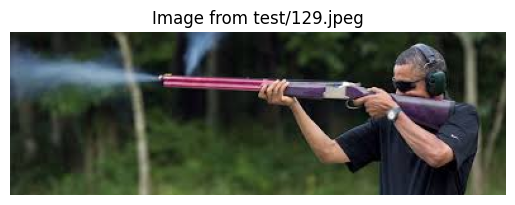

Image shape: (129, 392, 3)
Window size: (227, 227)
Step size: 32


In [ ]:
def sliding_window(image, step_size, window_size):
    """
    Slide a window across the image
    """
    for y in range(0, image.shape[0] - window_size[1] + 1, step_size):
        for x in range(0, image.shape[1] - window_size[0] + 1, step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

# Example usage
image_path = 'test/129.jpeg'  # Replace with the actual image file name
image = cv2.imread(image_path)

if image is None:
    print(f"Error: Could not load image from {image_path}")
else:
    # Convert image from BGR to RGB for plotting
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.title(f'Image from {image_path}')
    plt.axis('off')
    plt.show()

    window_size = (227, 227)  # Typical AlexNet input size
    step_size = 32

    # Print image dimensions and window settings
    print(f"Image shape: {image.shape}")
    print(f"Window size: {window_size}")
    print(f"Step size: {step_size}")

    for (x, y, window) in sliding_window(image, step_size, window_size):
        print(f"Window position: ({x}, {y}), Window shape: {window.shape}")
        if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
            print(f"Skipping incomplete window at ({x}, {y})")
            continue

#**Loss Functions and Training**
Defining the data loader, loss functions and the training loop.

This code block defines the data loading process for training and validating the Overfeat model on the Guns Object Detection dataset.

Importing Necessary Libraries:

Libraries for handling datasets (torch, torch.utils.data, os, cv2, numpy), and data transformations (torchvision.transforms).
GunDataset Class:

Initialization (__init__): Sets up the dataset by specifying the folders for images and labels, as well as any transformations. Lists all image files in the specified folder.
Length (__len__): Returns the total number of images in the dataset.
Get Item (__getitem__): Loads an image and its corresponding label, processes the bounding boxes, and applies transformations:
Reads and converts the image to RGB format.
Reads the label file, extracting the number of objects and their bounding box coordinates.
Pads bounding boxes to a maximum number of objects to ensure consistent tensor size.
Applies transformations to the image.
Data Transformations:

Converts images to tensors.
Resizes images to 227x227 pixels (the input size for the model).
Normalizes the images using mean and standard deviation values.
Creating Dataset Instances:

train_dataset: Dataset for training, using images and labels from the 'train' folder.
val_dataset: Dataset for validation, using images and labels from the 'val' folder.
Creating Data Loaders:

train_loader: DataLoader for training, with a batch size of 16 and shuffling enabled.
val_loader: DataLoader for validation, with a batch size of 16 and shuffling disabled.
Output:

Prints the number of samples in the training and validation datasets to verify the data loading process.
This setup ensures that the data is properly prepared and loaded for training and validation, with appropriate transformations and batching.

### Data Loader Definition

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import cv2
import numpy as np

class GunDataset(Dataset):
    def __init__(self, image_folder, label_folder, transform=None, max_objects=20):
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpeg')]
        self.max_objects = max_objects

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label_name = os.path.join(self.label_folder, self.image_files[idx].replace('.jpeg', '.txt'))

        with open(label_name, 'r') as file:
            lines = file.readlines()
            num_objects = int(lines[0].strip())
            bboxes = []
            for line in lines[1:]:
                bbox = list(map(int, line.strip().split()))
                bboxes.append(bbox)

        bboxes = np.array(bboxes, dtype=np.float32)  # Ensure bounding boxes are float32

        # Ensure the number of bounding boxes does not exceed max_objects
        if bboxes.shape[0] > self.max_objects:
            bboxes = bboxes[:self.max_objects]
            num_objects = self.max_objects

        # Pad bboxes to max_objects
        padded_bboxes = np.zeros((self.max_objects, 4), dtype=np.float32)  # Ensure padding is float32
        padded_bboxes[:bboxes.shape[0], :] = bboxes

        # Ensure labels are within the correct range
        num_objects = min(num_objects, 1)  # Convert any value greater than 1 to 1 (assuming binary classification)

        if self.transform:
            image = self.transform(image)

        return image, num_objects, padded_bboxes

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((227, 227)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset instances
train_dataset = GunDataset(image_folder='train', label_folder='train', transform=transform)
val_dataset = GunDataset(image_folder='val', label_folder='val', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")


Number of training samples: 199
Number of validation samples: 67


## Training Loop

This code cell defines and executes the training loop for the Overfeat model using the Guns Object Detection dataset.

Importing Libraries:

optim: For defining the optimizer.

nn.functional: For additional neural network functions.

Defining Loss Functions:

criterion_class: Cross-Entropy Loss for classification.

criterion_bbox: Mean Squared Error Loss (L2 Loss) for bounding box regression.

Optimizer:

optimizer: Adam optimizer with a learning rate of 0.001 to update model parameters.

Training Function:

Initialization: Sets the model to training mode and initializes running loss.

Epoch Loop: Iterates over the specified number of epochs.

Batch Loop: Iterates over batches of images, labels, and bounding boxes from the training data loader.
Converts data to float32 type for computation.
Resets gradients to zero.

Forward Pass: Passes the images through the model to get classification and bounding box outputs.

Classification Loss: Computes loss between predicted and true labels.

Bounding Box Loss: Computes loss for valid bounding boxes only.

Total Loss: Sums classification and bounding box losses.

Backward Pass: Computes gradients by backpropagation.

Optimizer Step: Updates model parameters.

Accumulates running loss.

Epoch Summary: Prints average loss for each epoch.

Training Execution:

Calls the train function with the defined model, training data loader, loss functions, optimizer, and number of epochs.

Output:

Prints the shape of the feature maps after the backbone and after flattening.
Outputs the average loss for each epoch, indicating the training progress.
This setup ensures that the model is properly trained by updating weights based on the combined classification and bounding box regression losses, improving its ability to detect and localize guns in images.

In [ ]:
import torch.optim as optim
import torch.nn.functional as F

criterion_class = nn.CrossEntropyLoss()
criterion_bbox = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, criterion_class, criterion_bbox, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels, bboxes in train_loader:
            images = images.to(torch.float32)
            labels = labels.to(torch.float32)
            bboxes = bboxes.to(torch.float32)

            optimizer.zero_grad()
            class_out, bbox_out = model(images)
            loss_class = criterion_class(class_out, labels.to(torch.long))  # CrossEntropyLoss expects long type

            # Calculate bounding box loss only on valid bboxes
            mask = labels > 0
            valid_bbox_out = bbox_out[mask]
            valid_bboxes = bboxes[mask]

            if valid_bbox_out.size(0) > 0:  # Ensure there are valid bboxes
                loss_bbox = criterion_bbox(valid_bbox_out, valid_bboxes)
                loss = loss_class + loss_bbox
            else:
                loss = loss_class

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')

# Train the model
train(model, train_loader, criterion_class, criterion_bbox, optimizer)


Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])


##Evaluation
To evaluate performance on validation set:


To assess the performance of our model on the validation set, we implemented several key functions. Below is a detailed explanation of the evaluation process:

Intersection over Union (IoU) Calculation:

Function: compute_iou(box1, box2)

Purpose: This function calculates the Intersection over Union (IoU) for two bounding boxes. The IoU is a metric used to measure the overlap between two bounding boxes. It is calculated as the ratio of the area of the intersection to the area of the union of the two bounding boxes.

Implementation:
Extracts the coordinates of the bounding boxes.
Computes the coordinates of the intersection area.
Calculates the area of the intersection.
Computes the areas of both bounding boxes.
Calculates the IoU as the intersection area divided by the union area.

Mean IoU (mIoU) Calculation:

Function: compute_mIoU(pred_boxes, true_boxes)

Purpose: This function calculates the mean IoU for all pairs of predicted and true bounding boxes. The mean IoU is the average IoU across all bounding boxes in the validation set.

Implementation:
Iterates through each pair of predicted and true bounding boxes.
Skips boxes that are all zeros (i.e., invalid or missing boxes).
Computes the IoU for valid pairs and appends them to a list.
Calculates the mean IoU by averaging the IoUs in the list.

Model Evaluation on Validation Set:

Function: evaluate(model, val_loader)

Purpose: This function evaluates the model's performance on the validation set by calculating the mean IoU (mIoU) and classification accuracy.

Implementation:
Sets the model to evaluation mode using model.eval().
Initializes the mIoU and accuracy counters.
Iterates through the validation data loader.
For each batch:
Converts images, labels, and bounding boxes to floating-point tensors.
Passes the images through the model to obtain class and bounding box predictions.
Computes classification predictions and updates the accuracy counter.
Masks the labels to identify valid bounding boxes.
Filters the bounding box predictions and true bounding boxes using the mask.
Calculates the mean IoU for the valid bounding boxes.
Returns the average mIoU and accuracy across the validation set.

In [ ]:
def compute_iou(box1, box2):
    """Compute the IoU of two bounding boxes."""
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2

    # Intersection area
    xi1 = max(x1, x1g)
    yi1 = max(y1, y1g)
    xi2 = min(x2, x2g)
    yi2 = min(y2, y2g)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    # Union Area
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area

def compute_mIoU(pred_boxes, true_boxes):
    """Compute the mean IoU for all pairs of predicted and true boxes."""
    ious = []
    for i in range(pred_boxes.shape[0]):
        for j in range(pred_boxes.shape[1]):
            pred = pred_boxes[i, j]
            true = true_boxes[i, j]
            print(f"Pred box: {pred}, True box: {true}")  # Debug print
            if np.all(pred == 0) or np.all(true == 0):  # Skip if either box is all zeros
                continue
            ious.append(compute_iou(pred, true))
    if len(ious) == 0:
        return 0.0
    return sum(ious) / len(ious)





# Define function to evaluate performance on validation set
def evaluate(model, val_loader):
    model.eval()
    mIoU = 0.0
    accuracy = 0.0
    total = 0
    with torch.no_grad():
        for images, labels, bboxes in val_loader:
            images = images.to(torch.float32)
            labels = labels.to(torch.float32)
            bboxes = bboxes.to(torch.float32)

            class_out, bbox_out = model(images)
            _, preds = torch.max(class_out, 1)
            accuracy += (preds == labels.to(torch.long)).sum().item()

            # Calculate mean IoU for all valid bounding boxes
            mask = labels > 0
            valid_bbox_out = bbox_out[mask]
            valid_bboxes = bboxes[mask]

            print(f"Valid bbox out shape: {valid_bbox_out.shape}")  # Debug print
            print(f"Valid bboxes shape: {valid_bboxes.shape}")  # Debug print

            mIoU += compute_mIoU(valid_bbox_out.cpu().numpy(), valid_bboxes.cpu().numpy())

            total += labels.size(0)
    return mIoU / total, accuracy / total

# Example usage
mIoU, accuracy = evaluate(model, val_loader)
print(f"Validation mIoU: {mIoU}, Accuracy: {accuracy}")





Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Valid bbox out shape: torch.Size([16, 20, 4])
Valid bboxes shape: torch.Size([16, 20, 4])
Pred box: [109.71435  68.53786 174.59329 119.94002], True box: [ 22. 102. 288. 162.]
Pred box: [19.585651 29.91398  44.5243   46.502644], True box: [ 41.   6. 271.  40.]
Pred box: [-0.20658672  6.355756    2.4334896   2.4885333 ], True box: [ 30.  54. 275.  92.]
Pred box: [6.6297507 4.3047514 8.639068  6.128273 ], True box: [0. 0. 0. 0.]
Pred box: [ 9.920637   4.9830723 13.536072   8.2092285], True box: [0. 0. 0. 0.]
Pred box: [1.6380966 4.75828   6.6866536 4.8926997], True box: [0. 0. 0. 0.]
Pred box: [ 5.5057554  4.76891   10.897981  11.709774 ], True box: [0. 0. 0. 0.]
Pred box: [15.332285   0.3684057 16.23731    5.2982845], True box: [0. 0. 0. 0.]
Pred box: [16.610008   2.634031  18.097454   2.8892722], True box: [0. 0. 0. 0.]
Pred box: [-0.01696348  2.7752435   4.8416443   3.0138035 ], True box

##Implementing L2 Loss for Bounding Box Regression


In this section, we implement the L2 loss function for bounding box regression using the mean squared error (MSE) loss provided by PyTorch. The L2 loss measures the squared differences between the predicted and true bounding box coordinates, encouraging the model to predict bounding boxes that closely match the ground truth.

In [ ]:
# L2 Loss for Bounding Box Regression
criterion_bbox = nn.MSELoss()  # This is equivalent to L2 loss

## Combining Softmax and L2 Loss for Total Loss

This section explains the process of combining the softmax loss for classification and the L2 loss for bounding box regression to form a total loss function used during model training. The combined loss allows the model to optimize both classification and localization tasks simultaneously.

Function Definition:

Function: train2

Purpose: Train the model using a combination of softmax loss for classification and L2 loss for bounding box regression.

Parameters:

model: The neural network model to be trained.

train_loader: DataLoader for the training dataset.

criterion_class: Loss function for classification (cross-entropy loss).

criterion_bbox: Loss function for bounding box regression (mean squared error loss).

optimizer: Optimization algorithm to update the model parameters.

num_epochs: Number of epochs to train the model.

Training Loop:

Initialization: The model is set to training mode using model.train(), and the running loss is initialized to 0.

Epoch Loop: The outer loop iterates over the specified number of epochs.

Batch Loop: The inner loop iterates over the batches of the training dataset.

Data Preparation: Images, labels, and bounding boxes are converted to floating-point tensors.

Zero Gradients: The gradients of the optimizer are reset to zero.

Forward Pass: The model outputs classification scores and bounding box predictions.

Loss Calculation:

Classification Loss: Calculated using the softmax loss (cross-entropy loss) between the predicted class scores and true labels.
Bounding Box Loss: Calculated using the L2 loss (mean squared error loss) between the predicted and true bounding boxes.

Total Loss: Sum of the classification loss and bounding box loss.

Backward Pass: The total loss is backpropagated to compute gradients.

Optimizer Step: The optimizer updates the model parameters based on the gradients.

Running Loss: The total loss for the batch is added to the running loss.

Epoch Loss Logging: The average loss for the epoch is printed.

In [ ]:
# Combining Softmax and L2 Loss
def train2(model, train_loader, criterion_class, criterion_bbox, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels, bboxes in train_loader:
            images = images.to(torch.float32)
            labels = labels.to(torch.float32)
            bboxes = bboxes.to(torch.float32)

            optimizer.zero_grad()
            class_out, bbox_out = model(images)
            loss_class = criterion_class(class_out, labels.to(torch.long))  # Softmax loss
            loss_bbox = criterion_bbox(bbox_out, bboxes)  # L2 loss
            total_loss = loss_class + loss_bbox  # Total loss
            total_loss.backward()
            optimizer.step()
            running_loss += total_loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')

# Train the model with the combined loss
train2(model, train_loader, criterion_class, criterion_bbox, optimizer)


Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])


##Implementing Non-Maximum Suppression (NMS)


In this section, we implement Non-Maximum Suppression (NMS) to improve the accuracy of our bounding box predictions by removing redundant or overlapping boxes. NMS ensures that only the most relevant bounding boxes are kept, based on their confidence scores, thereby reducing false positives.

Function Definitions
compute_iou(box1, box2):

Purpose: Compute the Intersection over Union (IoU) of two bounding boxes.

Parameters:

box1: Coordinates of the first bounding box.

box2: Coordinates of the second bounding box.

Output: The IoU value, representing the overlap between the two bounding boxes.

nms(boxes, scores, iou_threshold=0.5):

Purpose: Perform Non-Maximum Suppression to filter out redundant bounding boxes based on their IoU and confidence scores.

Parameters:

boxes: List of bounding boxes.

scores: List of confidence scores for each bounding box.

iou_threshold: IoU threshold to determine whether boxes are redundant.

Output: Indices of the bounding boxes to keep after applying NMS.
compute_mIoU(pred_boxes, true_boxes):

Purpose: Compute the mean IoU for all pairs of predicted and true bounding boxes.

Parameters:

pred_boxes: Array of predicted bounding boxes.

true_boxes: Array of ground truth bounding boxes.

Output: The mean IoU value for all bounding box pairs.

evaluate_with_nms(model, val_loader):

Purpose: Evaluate the model's performance on the validation set using Non-Maximum Suppression.

Parameters:

model: The neural network model to be evaluated.

val_loader: DataLoader for the validation dataset.

Output: Mean IoU and accuracy values for the validation set.

Implementation Steps

IoU Calculation:

The compute_iou function calculates the intersection area of two bounding boxes and divides it by their union area to get the IoU value.

Non-Maximum Suppression:

The nms function sorts the bounding boxes by their confidence scores in descending order.
It iterates through the boxes, keeping the one with the highest score and discarding others that have an IoU greater than the threshold with the kept box.
The function returns the indices of the bounding boxes to keep.

Mean IoU Calculation:

The compute_mIoU function computes the IoU for each pair of predicted and true bounding boxes.
It calculates the mean IoU by averaging the IoU values of all valid bounding box pairs.

Model Evaluation:

The evaluate_with_nms function evaluates the model's performance using the validation data.
It performs a forward pass through the model to obtain predicted class scores and bounding boxes.
It applies NMS to filter out redundant bounding boxes.
It computes the accuracy by comparing predicted labels with true labels.
It calculates the mean IoU for the valid bounding boxes after applying NMS.

In [ ]:
import numpy as np

def compute_iou(box1, box2):
    """Compute the IoU of two bounding boxes."""
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2

    # Intersection area
    xi1 = max(x1, x1g)
    yi1 = max(y1, y1g)
    xi2 = min(x2, x2g)
    yi2 = min(y2, y2g)
    inter_area = max(0, xi2 - xi1) * max(0, yi1 - yi2)

    # Union Area
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area

def nms(boxes, scores, iou_threshold=0.5):
    """Perform non-maximum suppression."""
    scores = np.array(scores)
    if scores.ndim != 1 or len(scores) == 0:
        return []

    indices = np.argsort(scores)[::-1]
    keep = []

    while len(indices) > 0:
        current = indices[0]
        keep.append(current)
        if len(indices) == 1:
            break
        rest = indices[1:]
        ious = np.array([compute_iou(boxes[current], boxes[i]) for i in rest])
        indices = rest[ious <= iou_threshold]

    return keep

def compute_mIoU(pred_boxes, true_boxes):
    """Compute the mean IoU for all pairs of predicted and true boxes."""
    ious = []
    for i in range(pred_boxes.shape[0]):
        for j in range(pred_boxes.shape[1]):
            pred = pred_boxes[i, j]
            true = true_boxes[i, j]
            if pred.shape[0] != 4 or true.shape[0] != 4:
                continue
            pred_box = pred[:4]
            true_box = true[:4]
            if np.all(pred_box == 0) or np.all(true_box == 0):  # Skip if either box is all zeros
                continue
            ious.append(compute_iou(pred_box, true_box))
    if len(ious) == 0:
        return 0.0
    return sum(ious) / len(ious)

def evaluate_with_nms(model, val_loader):
    model.eval()
    mIoU = 0.0
    accuracy = 0.0
    total = 0
    with torch.no_grad():
        for images, labels, bboxes in val_loader:
            images = images.to(torch.float32)
            labels = labels.to(torch.float32)
            bboxes = bboxes.to(torch.float32)

            class_out, bbox_out = model(images)
            _, preds = torch.max(class_out, 1)
            accuracy += (preds == labels.to(torch.long)).sum().item()

            # Apply NMS
            nms_boxes = []
            nms_scores = []
            for i in range(bbox_out.shape[0]):
                boxes = bbox_out[i].cpu().numpy()
                scores = class_out[i].cpu().numpy()
                keep = nms(boxes, scores)
                nms_boxes.append(boxes[keep])
                nms_scores.append(scores[keep])

            # Calculate mean IoU for all valid bounding boxes
            mask = labels > 0
            valid_bbox_out = bbox_out[mask]
            valid_bboxes = bboxes[mask]

            mIoU += compute_mIoU(valid_bbox_out.cpu().numpy(), valid_bboxes.cpu().numpy())
            total += labels.size(0)
    return mIoU / total, accuracy / total

# Evaluate the model with NMS
mIoU, accuracy = evaluate_with_nms(model, val_loader)
print(f"Validation mIoU with NMS: {mIoU}, Accuracy: {accuracy}")


Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([3, 256, 13, 13])
Shape after flattening: torch.Size([3, 43264])
Validation mIoU with NMS: 0.0023536568577951487, Accuracy: 1.0


##Trying Different Hyperparameters

In this section, we focus on tuning hyperparameters to optimize the performance of our object detection model. The hyperparameters we aim to adjust include learning rates and batch sizes. By systematically exploring different combinations, we identify the best set of hyperparameters that yield the highest mean Intersection over Union (mIoU) on the validation set.

Function Definition

hyperparameter_tuning(train_loader, val_loader):

Purpose: Find the optimal combination of learning rate and batch size to maximize the model's performance.

Parameters:

train_loader: DataLoader for the training dataset.

val_loader: DataLoader for the validation dataset.

Output: The best hyperparameters found during the tuning process.

Implementation Steps

Hyperparameter Initialization:

We define the range of hyperparameters to explore:

learning_rates: A list of learning rates to test.

batch_sizes: A list of batch sizes to test.

We initialize variables to keep track of the best mIoU and the corresponding hyperparameters.

Iterate Over Hyperparameters:

We use nested loops to iterate over all combinations of learning rates and batch sizes.

For each combination, we:
Print the current learning rate and batch size being tested.
Initialize the model, optimizer, and loss functions.
Create DataLoaders for the training and validation datasets with the current batch size.
Train the model with the current hyperparameters using the train function.
Evaluate the model's performance on the validation set using the evaluate_with_nms function.

Evaluate Performance:

After evaluating the model, we print the mIoU and accuracy for the current combination of hyperparameters.
If the mIoU is the highest observed so far, we update the best mIoU and the best hyperparameters.

Return Best Hyperparameters:

After testing all combinations, we print and return the best hyperparameters.

In [ ]:
def hyperparameter_tuning(train_loader, val_loader):
    learning_rates = [0.001, 0.0005]
    batch_sizes = [16, 32]
    best_mIoU = 0.0
    best_params = None

    for lr in learning_rates:
        for batch_size in batch_sizes:
            print(f"Testing with learning rate: {lr} and batch size: {batch_size}")
            model = Overfeat(max_objects=20)
            optimizer = optim.Adam(model.parameters(), lr=lr)
            criterion_class = nn.CrossEntropyLoss()
            criterion_bbox = nn.MSELoss()

            # Train with current hyperparameters
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
            train(model, train_loader, criterion_class, criterion_bbox, optimizer, num_epochs=5)

            # Evaluate on validation set
            mIoU, accuracy = evaluate_with_nms(model, val_loader)
            print(f"mIoU: {mIoU}, Accuracy: {accuracy}")

            if mIoU > best_mIoU:
                best_mIoU = mIoU
                best_params = {'learning_rate': lr, 'batch_size': batch_size}

    print(f"Best hyperparameters found: {best_params}")
    return best_params

# Run hyperparameter tuning
best_params = hyperparameter_tuning(train_loader, val_loader)


Testing with learning rate: 0.001 and batch size: 16
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 

##Final Performance on Test Set

In this section, we evaluate the final performance of our object detection model on the test set using the best hyperparameters found during the tuning process. This involves loading the best model, training it with the optimized parameters, and then evaluating it on the test dataset.

Step-by-Step Explanation

Check for Best Parameters:

The code first checks if the best_params variable is not None, indicating that the hyperparameter tuning process has identified a set of optimal parameters.

Reload Best Model:

If the best parameters are found, the code reloads the Overfeat model and sets up the optimizer and loss functions (criterion_class for classification and criterion_bbox for bounding box regression) using the best learning rate (lr) and batch size (batch_size).

Data Loaders for Training and Validation:

Data loaders for the training and validation datasets are created using the best batch size found during hyperparameter tuning. The training data loader shuffles the data, while the validation data loader does not.

Train the Model:

The model is then trained using the optimal hyperparameters for a specified number of epochs (10 in this case).

Final Performance on Test Set:

The test dataset is prepared using the GunDataset class, with the appropriate image and label folders specified. The test data loader is created with the best batch size.

Evaluate the Model on Test Set:

The best model is evaluated on the test set using the evaluate_with_nms function, which calculates the mean Intersection over Union (mIoU) and accuracy. These metrics are printed for the test set.

No Best Parameters Found:

If no best parameters are found during the tuning process, a message is printed indicating that the test set evaluation is skipped.


This code block is crucial as it ensures that the model's performance is assessed on unseen data using the best possible configuration found during the hyperparameter tuning phase. This step provides an unbiased evaluation of the model's generalization capabilities and its effectiveness in real-world scenarios. The final performance metrics (mIoU and accuracy) on the test set are essential for comparing different models and configurations and for making informed decisions about deploying the model.

In [ ]:
if best_params is not None:
    # Reload best model
    model = Overfeat(max_objects=20)
    optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])
    criterion_class = nn.CrossEntropyLoss()
    criterion_bbox = nn.MSELoss()

    train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)
    train(model, train_loader, criterion_class, criterion_bbox, optimizer, num_epochs=10)

    # Final Performance on Test Set
    test_dataset = GunDataset(image_folder='test', label_folder='test', transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)

    # Evaluate the best model on the test set
    test_mIoU, test_accuracy = evaluate_with_nms(model, test_loader)
    print(f"Test mIoU: {test_mIoU}, Test Accuracy: {test_accuracy}")
else:
    print("No best parameters found, skipping test set evaluation.")





Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])
Shape after backbone: torch.Size([16, 256, 13, 13])
Shape after flattening: torch.Size([16, 43264])


#Visualization of Detected Gun Object


In this section, we implement a visualization function to plot the detected gun objects with their corresponding bounding boxes on an image. This visualization helps in understanding how well our model performs in detecting and localizing objects in images.


Step-by-Step Explanation

Importing Required Library:

The matplotlib.patches module is imported as patches to create rectangular patches for bounding boxes.


Define Plot Function:

The plot_detected_image function takes an image path, bounding boxes, and their scores to plot the image with detected bounding boxes.

Load Image:

The image is loaded using cv2.imread. If the image cannot be loaded, an error message is printed.

Convert Image Format:

The image is converted from BGR to RGB format using cv2.cvtColor for correct display with Matplotlib.

Plot Bounding Boxes:

For each bounding box and score, a rectangle is drawn on the image if the score is above a threshold (0.5 in this case). The bounding box coordinates are extracted, and a rectangular patch is added to the plot. The score is displayed as text near the bounding box.

Apply NMS:

Non-Maximum Suppression (NMS) is applied to the predicted bounding boxes to filter out redundant boxes. The filtered boxes and scores are obtained.

This code block is crucial for visualizing the results of our object detection model. By plotting the detected bounding boxes on test images, we can qualitatively assess the model's performance and identify areas where it may need improvement. Visualization is an essential step in understanding the effectiveness of our detection algorithm and in presenting the results in a clear and interpretable manner.

In [ ]:
import matplotlib.patches as patches

def plot_detected_image(image_path, boxes, scores):
    """Plot image with detected bounding boxes."""
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image from {image_path}")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    for box, score in zip(boxes, scores):
        if score > 0.5:  # Threshold to filter weak detections
            x1, y1, x2, y2 = box
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.text(x1, y1, f'{score:.2f}', bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()

# Example usage after evaluating on the test set
image_path = 'test/147.jpeg'
test_dataset = GunDataset(image_folder='test', label_folder='test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()
with torch.no_grad():
    for images, labels, bboxes in test_loader:
        images = images.to(torch.float32)
        class_out, bbox_out = model(images)
        _, preds = torch.max(class_out, 1)

        # Apply NMS
        boxes = bbox_out[0].cpu().numpy()
        scores = class_out[0].cpu().numpy()
        keep = nms(boxes, scores)
        nms_boxes = boxes[keep]
        nms_scores = scores[keep]

        plot_detected_image(image_path, nms_boxes, nms_scores)
        break  # Plot the first test image and break
